# 1d Wave Equation on unbounded domain with step velocity, solved by PINN
---

## Direct Problem
Consider the 1d wave equation
$$
\frac{\partial^2 u}{\partial t^2} - \frac{\partial}{\partial x}\left(c(x)^2\frac{\partial u}{\partial x}\right) = 0,
$$
with IC
$$
u(x, 0) = g(x), \frac{\partial u}{\partial t}(x, 0) = 0,
$$

The initial condition is a gaussian shock
$$
g(x) = \left\{
\begin{aligned}
&\frac{1}{2}\exp(-400(x-0.25)^2), &\quad x \in [0.1, 0.4], \\[0.3cm]
&0, &\quad \text{others}.
\end{aligned}
\right.
$$

The spatial domain for this problem is $[0, 1]$. However, the wave is allowed to propagate freely across the boundaries without any constraints, through which a boundless wave propagation is mimicked.

## Inverse Problem

Consider the step wave velocity
$$
c(x) = \left\{
\begin{aligned}
&0.5, &x \ge 0.6, \\
&1.0, &x < 0.6, \\
\end{aligned}
\right.
$$
Given a solution trajectory (possibly with noise)
$$
\{u(x, t_1), u(x, t_2), \cdots, u(x, t_m)\}, \quad x = (x_1, x_2, \cdots, x_n),
$$
we want to recover the spatial distribution of the velocity field $c = c(x)$.

## Structure
Direct model:
$$
\Phi_d: (x, t) \to (u(x, t), v(x, t)).
$$
Inverse model:
$$
\Phi_i: (x, t, \Phi_d(x, t)) \to c(x)
$$
Loss:
$$
\mathcal{L} = \mathcal{L}_r(x, t) + \mathcal{L}_{i}(x, t) + \mathcal{L}_f(x, t),
$$
where $\mathcal{L}_r, \mathcal{L}_i, \mathcal{L}_f$ represents for the loss of equation residue, initial condition, and numerical solution.

## Real data
We use a finite difference numerical solver to get the real data for training. In order to minic the unbounded domain, We expand the spatial domain to [-5, 5], and extract the splution on $x\in [0, 1]$ as the real data for training.

## Requirements:
- python >= 3.6
- tensorflow >= 2.0

In [12]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from utils_1d import *
from utils import *
import time

plt.rcParams.update(plt.rcParamsDefault)
tf.keras.backend.set_floatx("float32")
# tf.config.set_visible_devices([], 'GPU')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Specify the profiles of the 1d wave problem

In [2]:
np.random.seed(1)

domain = [0.0, 1.0] # domain for the problem
domain_num = [-5.0, 5.0] # domain for finite difference solver
T_max = 1.0

domain_gaussian_pulse = [0.1, 0.5] # domain for Gaussian pulse (of initial condition)
velocity_interface = [0.6] # interface of the step velocity field
velocity_field = [0.5, 1.0]

# initial condition profile
func_ic = lambda x: np.piecewise(x,
                                [x >= domain_gaussian_pulse[1], (x >= domain_gaussian_pulse[0]) & (x < domain_gaussian_pulse[1]), x < domain_gaussian_pulse[0]],
                                [0,
                                lambda y: 1/2*np.exp(-400*(y-sum(domain_gaussian_pulse)/2)**2),
                                0])
# velocity field profile
func_c = lambda x: np.piecewise(x,
							   [x >= velocity_interface[0], x < velocity_interface[0]],
							   velocity_field)

## Define the direct model and inverse model

In [3]:
direct_model = keras.models.Sequential([
    keras.layers.Dense(32, input_shape = (2, ),  # (x, t)
                       activation = "tanh"),
    keras.layers.Dense(32,
                      activation = "tanh"),
    keras.layers.Dense(1) # (u)
])

inverse_model = keras.models.Sequential([
    keras.layers.Dense(32, input_shape = (3, ), # (x, t, u)
                       activation = "tanh"),
    keras.layers.Dense(32,
                      activation = "tanh"),
    keras.layers.Dense(1,
					  activation = 'softplus') # (c)
])

## Define the loss function and training step

In [4]:
loss_func = keras.losses.MeanSquaredError()

def get_residue_loss(tape, x, t, u, c):
	du_dx = tape.gradient(u, x)
	du_dxx = tape.gradient(du_dx, x)
	c2du_dx = tf.square(c)*du_dx
	dc2du_dxx = tape.gradient(c2du_dx, x)
	
	du_dt = tape.gradient(u, t)
	du_dtt = tape.gradient(du_dt, t)
	return loss_func(du_dtt, dc2du_dxx)

def get_initial_loss(tape, x, t, u, c, u_true):
	initial_residue_loss = get_residue_loss(tape, x, t, u, c)
	du_dt = tape.gradient(u, t)
	initial_func_loss = loss_func(u, u_true) + loss_func(du_dt, tf.zeros_like(du_dt))
	return initial_residue_loss, initial_func_loss

def get_num_loss(tape, x, t, u, c, u_true):
	num_residue_loss = get_residue_loss(tape, x, t, u, c)
	num_func_loss = loss_func(u, u_true)
	return num_residue_loss, num_func_loss

@tf.function
def forward(x, t):
	u = direct_model(tf.concat([x, t], axis = 1))
	c = inverse_model(tf.concat([x, t, u], axis = 1))
	return u, c

@cast_to_tf_constant(tf.float32)
def train_step(x_collocation, t_collocation, 
               x_ic, t_ic, u_ic_true,
			   x_num, t_num, u_num_true):
	
	with tf.GradientTape(persistent = True) as tape:
		tape.watch(x_collocation)
		tape.watch(t_collocation)
		tape.watch(x_ic)
		tape.watch(t_ic)
		tape.watch(x_num)
		tape.watch(t_num)
				
		u_collocation, c_collocation = forward(x_collocation, t_collocation)
		u_ic, c_ic = forward(x_ic, t_ic)
		u_num, c_num = forward(x_num, t_num)
		
		collocation_loss = get_residue_loss(tape, x_collocation, t_collocation, u_collocation, c_collocation)
		ic_residue_loss, ic_func_loss = get_initial_loss(tape, x_ic, t_ic, u_ic, c_ic, u_ic_true)
		num_residue_loss, num_func_loss = get_num_loss(tape, x_num, t_num, u_num, c_num, u_num_true)
		
		loss = collocation_loss + ic_residue_loss + ic_func_loss + num_residue_loss + num_func_loss
    
	grads = tape.gradient(loss, direct_model.trainable_variables + inverse_model.trainable_variables)
	optimizer.apply_gradients(zip(grads, direct_model.trainable_variables + inverse_model.trainable_variables))
	del tape
	
	return loss, {
		"collocation": collocation_loss,
		"ic_residue": ic_residue_loss,
		"ic_func": ic_func_loss,
		"solution_residue": num_residue_loss,
		"solution": num_func_loss
	}

## Generate training points for collocation and initial condition (i.e., unlabelled data)

In [5]:
n_domain = 5000
n_ic = 200
    
x_collocation = transform(np.random.random((n_domain, 1)), *domain).reshape((-1, 1))
t_collocation = transform(np.random.random((n_domain, 1)), 0, T_max).reshape((-1, 1))
x_ic = transform(np.random.random((n_ic, 1)), *domain).reshape((-1, 1))
t_ic = np.zeros_like(x_ic)

func_ic = lambda x: np.piecewise(x, 
                                [x >= domain_gaussian_pulse[1], (x >= domain_gaussian_pulse[0]) & (x < domain_gaussian_pulse[1]), x < domain_gaussian_pulse[0]],
                                [0,
                                lambda y: 1/2*np.exp(-400*(y-sum(domain_gaussian_pulse)/2)**2),
                                0])

u_ic_true = func_ic(x_ic.flatten()).reshape((-1, 1))

## Generate numerical solution for inverse problem

In [8]:
dx_num = 0.001
dt_num = 0.0001
u_num, x_num, t_num = numerical_solver_PML(I = func_ic,
                                          V = lambda x: np.zeros_like(x),
                                          f = lambda x, t: np.zeros_like(x),
                                          c = func_c,
                                          L1 = domain_num[0],
                                          L2 = domain_num[1],
                                          dx = dx_num,
                                          T = T_max,
                                          dt = dt_num,
                                          cmax = 1.0,)
                                          
index_domain = cut(x_num, domain)[0]
x_num = x_num[index_domain]
u_num = u_num[:, index_domain]
print("spatial mesh size:", x_num.shape)
print("temporal mesh size:", t_num.shape)

x_sample_rate = 5
t_sample_rate = 500

x_num_sampled = x_num[::x_sample_rate]
t_num_sampled = t_num[::t_sample_rate]
xt_num_train = tensor_grid([t_num_sampled, x_num_sampled])
xt_num_train[:, [0, 1]] = xt_num_train[:, [1, 0]]
x_num_train, t_num_train = xt_num_train[:, 0:1], xt_num_train[:, 1:2]

u_num_train = u_num[::t_sample_rate, ::x_sample_rate]
u_num_train_1d = u_num_train.reshape((-1, 1))

print("size of spatial data:", x_num_sampled.shape)
print("size of temporal data:", t_num_sampled.shape)
print("size of numerical data:", u_num_train_1d.shape)

Courant Number: 0.1
spatial mesh size: (1001,)
temporal mesh size: (10001,)
size of spatial data: (201,)
size of temporal data: (21,)
size of numerical data: (4221, 1)


## plot numerical data

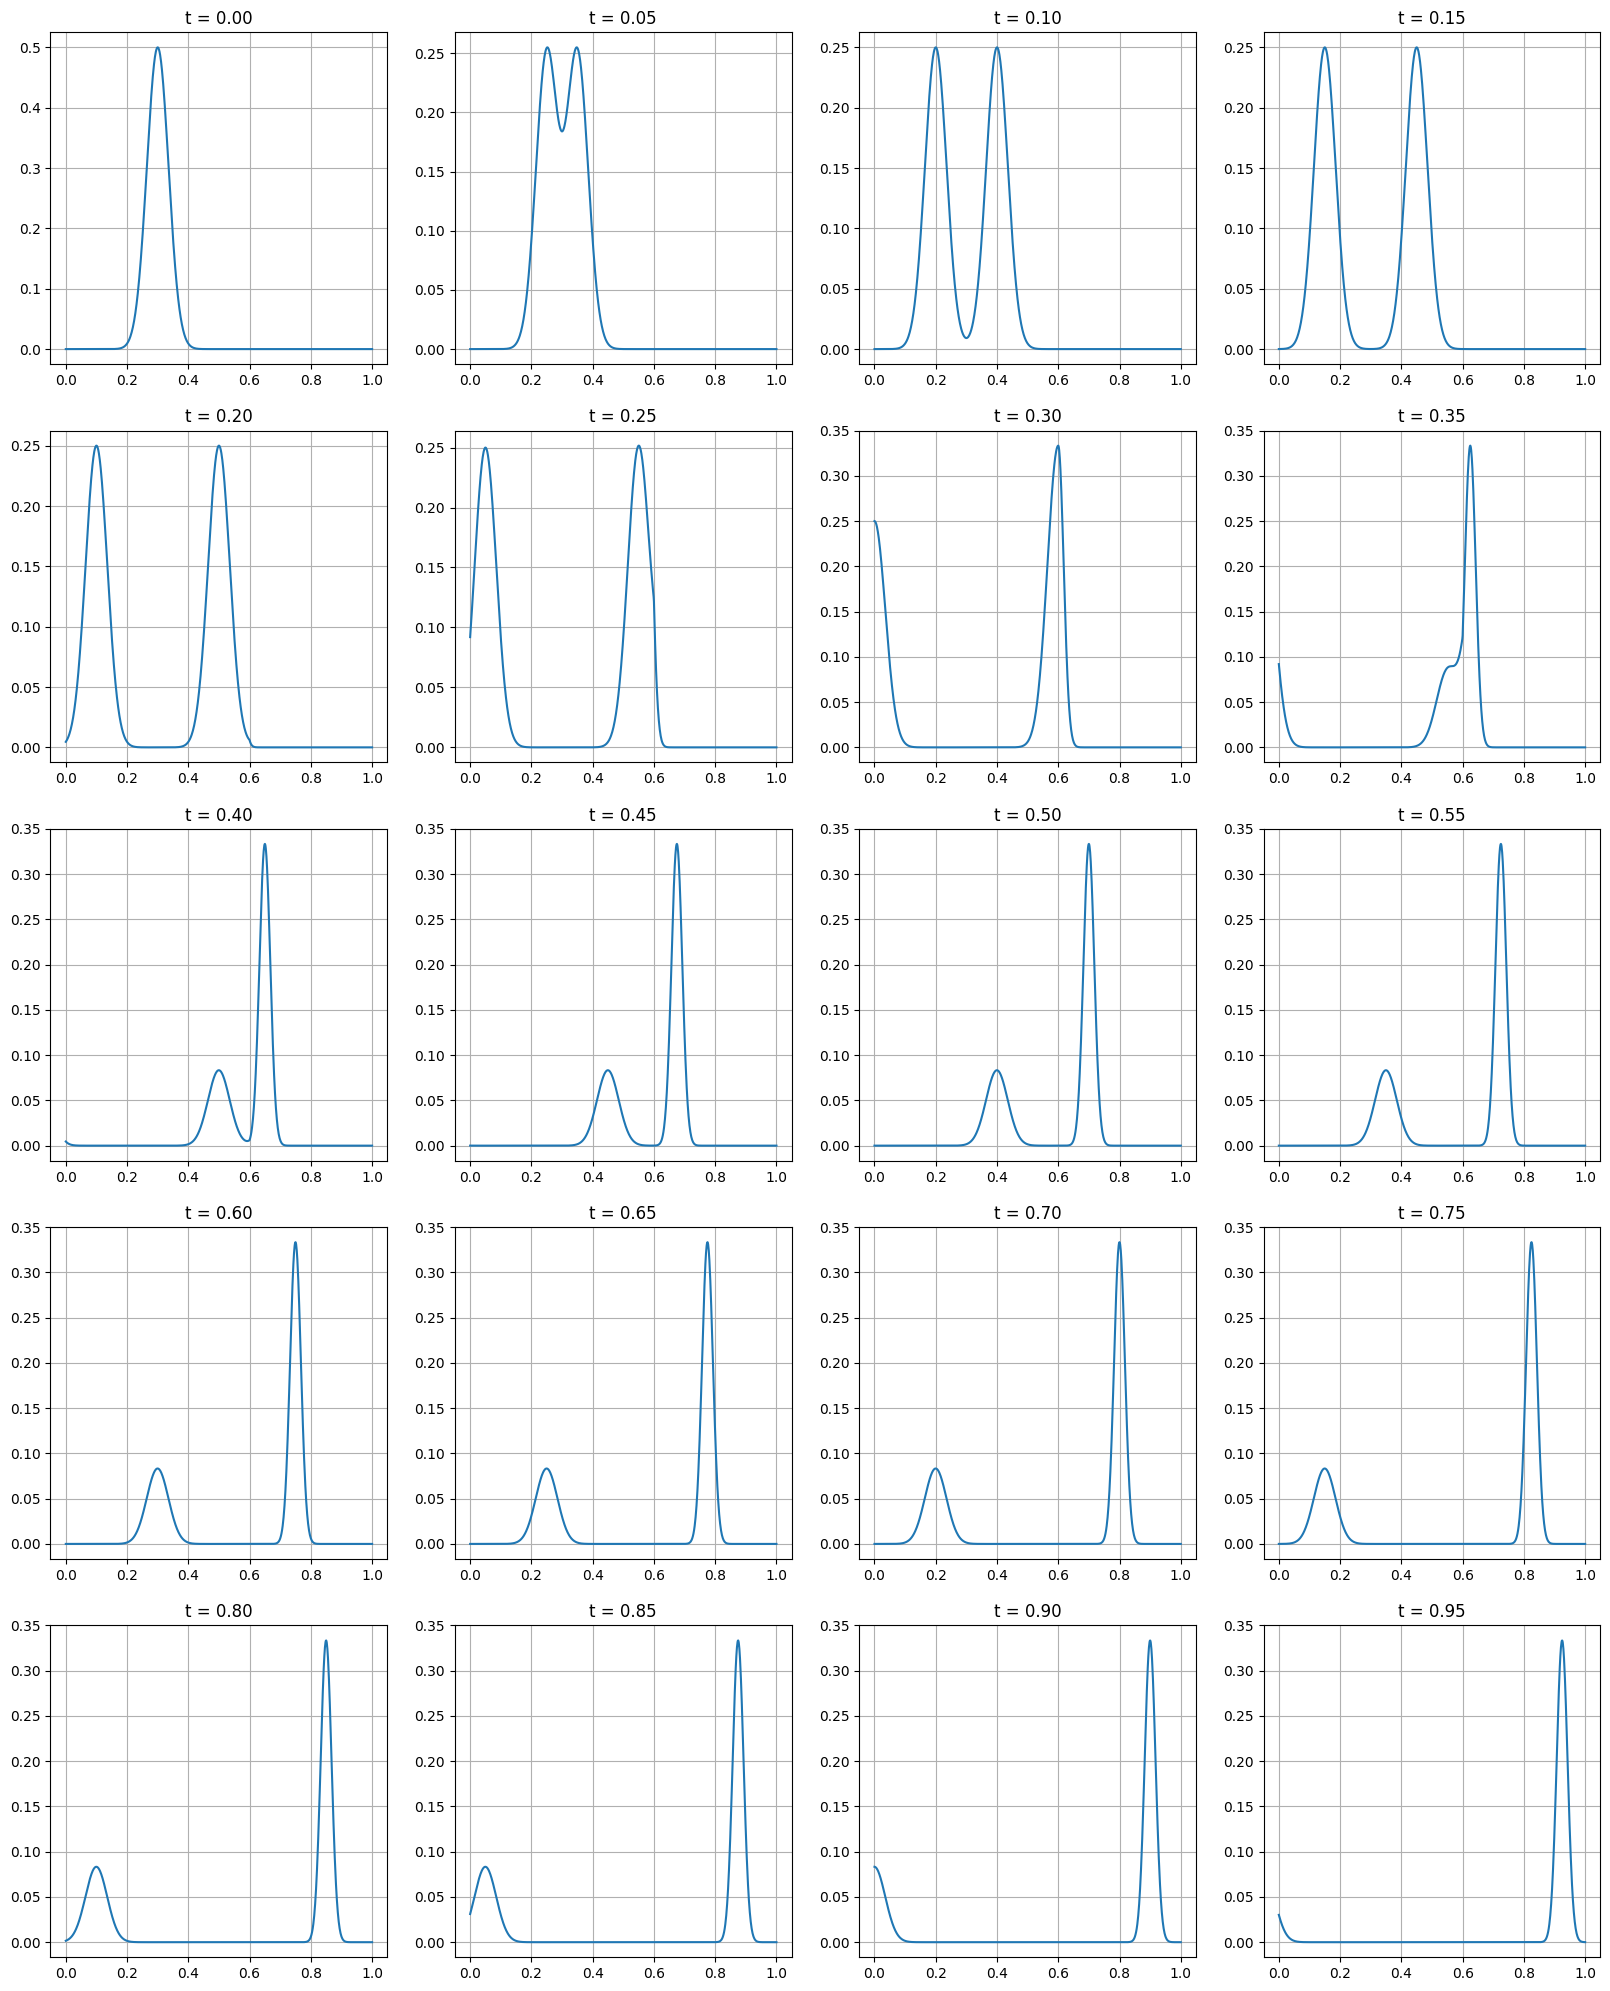

In [11]:
print_every = int(T_max / dt_num)//20

f, ax = plt.subplots(5, 4, figsize = (20, 25))
for i in range(20):
    ax[i // 4][i % 4].plot(x_num, np.squeeze(u_num[i*print_every, :]))
    ax[i // 4][i % 4].set_title("t = {0:.2f}".format(t_num[i*print_every]))
    ax[i // 4][i % 4].grid()
plt.show()

## training

In [14]:
optimizer = keras.optimizers.Adam(lr = 0.1)

for epoch in range(5000):
    loss, loss_dict = train_step(x_collocation, t_collocation,
								 x_ic, t_ic, u_ic_true,
								 x_num_train, t_num_train, u_num_train_1d)
    if epoch % 100 == 0:
        print("{}, Epoch: {}, Loss: {:.4e}, collocation: {:.4e}, ic: {:.4e}, ic residue: {:.4e}, solution: {:.4e}, solution residue: {:.4e}".format( 
					time.strftime("%D, %H:%M:%S", time.localtime()), epoch, 
					loss.numpy(), loss_dict["collocation"].numpy(), loss_dict["ic_func"].numpy(), loss_dict["ic_residue"].numpy(), 
					loss_dict["solution"].numpy(), loss_dict["solution_residue"].numpy()))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for keyword: 1, expecting 2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for keyword: 1, expecting 2
04/05/20, 15:51:48, Epoch: 0, Loss: 3.1390e-01, collocation: 4.3796e-03, ic: 2.5315e-01, ic residue: 1.2662e-02, solution: 3.9162e-02, solution residue: 4.5481e-03
04/05/20, 15:53:00, Epoch: 100, Loss: 1.8892e-02, collocation: 2.7756e-05, ic: 1.3971e-02, ic residue: 4.6375e-05, solution: 4.8186e-03, solution residue: 2.8247e-05
04/05/20, 15:54:11, Epoch: 200, Loss: 1.8820e-02, collocation: 2.2854e-05, ic: 1.3900e-02, ic residue: 4.0253e-05, solution: 4.8334e-03, solution residue: 2.3357e-05
04/05/20, 15:55:20, Epoch: 300, Loss: 1.8766e-02, collocation: 1.7857e-05,

04/05/20, 16:28:42, Epoch: 3200, Loss: 1.8046e-02, collocation: 4.4539e-06, ic: 1.3167e-02, ic residue: 3.6769e-06, solution: 4.8658e-03, solution residue: 4.3909e-06
04/05/20, 16:29:49, Epoch: 3300, Loss: 1.8034e-02, collocation: 4.7450e-06, ic: 1.3159e-02, ic residue: 3.7151e-06, solution: 4.8620e-03, solution residue: 4.6636e-06
04/05/20, 16:30:58, Epoch: 3400, Loss: 1.8021e-02, collocation: 5.0045e-06, ic: 1.3150e-02, ic residue: 3.6838e-06, solution: 4.8572e-03, solution residue: 4.9027e-06
04/05/20, 16:32:06, Epoch: 3500, Loss: 1.8006e-02, collocation: 5.2023e-06, ic: 1.3141e-02, ic residue: 3.5650e-06, solution: 4.8510e-03, solution residue: 5.0788e-06
04/05/20, 16:33:18, Epoch: 3600, Loss: 1.7987e-02, collocation: 5.2870e-06, ic: 1.3131e-02, ic residue: 3.3385e-06, solution: 4.8428e-03, solution residue: 5.1415e-06
04/05/20, 16:34:27, Epoch: 3700, Loss: 1.7963e-02, collocation: 5.2355e-06, ic: 1.3117e-02, ic residue: 3.0311e-06, solution: 4.8332e-03, solution residue: 5.0711e-0

In [15]:
optimizer = keras.optimizers.Adam(lr = 0.01)

for epoch in range(20000):
    loss, loss_dict = train_step(x_collocation, t_collocation,
								 x_ic, t_ic, u_ic_true,
								 x_num_train, t_num_train, u_num_train_1d)
    if epoch % 100 == 0:
        print("{}, Epoch: {}, Loss: {:.4e}, collocation: {:.4e}, ic: {:.4e}, ic residue: {:.4e}, solution: {:.4e}, solution residue: {:.4e}".format( 
					time.strftime("%D, %H:%M:%S", time.localtime()), epoch, 
					loss.numpy(), loss_dict["collocation"].numpy(), loss_dict["ic_func"].numpy(), loss_dict["ic_residue"].numpy(), 
					loss_dict["solution"].numpy(), loss_dict["solution_residue"].numpy()))

04/05/20, 16:50:02, Epoch: 0, Loss: 2.0560e-02, collocation: 4.0900e-06, ic: 1.4856e-02, ic residue: 4.9094e-06, solution: 5.6908e-03, solution residue: 4.3402e-06
04/05/20, 16:51:12, Epoch: 100, Loss: 1.8006e-02, collocation: 3.4032e-06, ic: 1.3111e-02, ic residue: 8.7021e-06, solution: 4.8791e-03, solution residue: 3.5840e-06
04/05/20, 16:52:22, Epoch: 200, Loss: 1.7926e-02, collocation: 7.1551e-07, ic: 1.3085e-02, ic residue: 2.0198e-06, solution: 4.8376e-03, solution residue: 7.5179e-07
04/05/20, 16:53:32, Epoch: 300, Loss: 1.7621e-02, collocation: 7.3285e-06, ic: 1.2880e-02, ic residue: 1.2392e-06, solution: 4.7234e-03, solution residue: 8.1349e-06
04/05/20, 16:54:43, Epoch: 400, Loss: 1.7405e-02, collocation: 9.2027e-06, ic: 1.2614e-02, ic residue: 6.0793e-06, solution: 4.7657e-03, solution residue: 9.8220e-06
04/05/20, 16:55:53, Epoch: 500, Loss: 1.6570e-02, collocation: 2.7014e-05, ic: 1.1573e-02, ic residue: 2.5291e-05, solution: 4.9172e-03, solution residue: 2.8401e-05
04/05/

04/05/20, 17:48:17, Epoch: 5000, Loss: 1.0048e-02, collocation: 3.7858e-05, ic: 2.9940e-03, ic residue: 1.7896e-05, solution: 6.9597e-03, solution residue: 3.8665e-05
04/05/20, 17:49:25, Epoch: 5100, Loss: 9.7282e-03, collocation: 5.2411e-05, ic: 2.7407e-03, ic residue: 2.1635e-05, solution: 6.8559e-03, solution residue: 5.7588e-05
04/05/20, 17:50:35, Epoch: 5200, Loss: 9.6913e-03, collocation: 4.9686e-05, ic: 2.4967e-03, ic residue: 1.8819e-05, solution: 7.0766e-03, solution residue: 4.9450e-05
04/05/20, 17:51:48, Epoch: 5300, Loss: 1.0028e-02, collocation: 3.0230e-05, ic: 2.7119e-03, ic residue: 2.3423e-05, solution: 7.2317e-03, solution residue: 3.0309e-05
04/05/20, 17:52:59, Epoch: 5400, Loss: 9.5152e-03, collocation: 3.5090e-05, ic: 2.5043e-03, ic residue: 1.7662e-05, solution: 6.9218e-03, solution residue: 3.6350e-05
04/05/20, 17:54:08, Epoch: 5500, Loss: 9.4942e-03, collocation: 3.5333e-05, ic: 2.4799e-03, ic residue: 2.2820e-05, solution: 6.9147e-03, solution residue: 4.1439e-0

04/05/20, 18:41:07, Epoch: 10000, Loss: 9.4877e-03, collocation: 1.6943e-04, ic: 2.1736e-03, ic residue: 1.9275e-04, solution: 6.7790e-03, solution residue: 1.7290e-04
04/05/20, 18:42:00, Epoch: 10100, Loss: 1.0308e-02, collocation: 5.4661e-05, ic: 3.1913e-03, ic residue: 4.2320e-05, solution: 6.9610e-03, solution residue: 5.8280e-05
04/05/20, 18:42:54, Epoch: 10200, Loss: 9.7471e-03, collocation: 2.7150e-05, ic: 2.8333e-03, ic residue: 6.7479e-06, solution: 6.8482e-03, solution residue: 3.1707e-05
04/05/20, 18:43:48, Epoch: 10300, Loss: 9.0681e-03, collocation: 3.6180e-05, ic: 2.1689e-03, ic residue: 7.7630e-06, solution: 6.8169e-03, solution residue: 3.8263e-05
04/05/20, 18:44:41, Epoch: 10400, Loss: 9.0228e-03, collocation: 3.3376e-05, ic: 2.1096e-03, ic residue: 6.4115e-06, solution: 6.8380e-03, solution residue: 3.5361e-05
04/05/20, 18:45:33, Epoch: 10500, Loss: 9.0427e-03, collocation: 5.6480e-05, ic: 2.0801e-03, ic residue: 3.2536e-05, solution: 6.8152e-03, solution residue: 5.8

04/05/20, 19:26:09, Epoch: 14900, Loss: 8.7231e-03, collocation: 5.2144e-05, ic: 1.8762e-03, ic residue: 5.7250e-05, solution: 6.6834e-03, solution residue: 5.4158e-05
04/05/20, 19:27:02, Epoch: 15000, Loss: 8.9330e-03, collocation: 5.9201e-05, ic: 2.1073e-03, ic residue: 6.2491e-05, solution: 6.6435e-03, solution residue: 6.0457e-05
04/05/20, 19:27:55, Epoch: 15100, Loss: 8.6029e-03, collocation: 3.4179e-05, ic: 1.9119e-03, ic residue: 1.9275e-05, solution: 6.6020e-03, solution residue: 3.5455e-05
04/05/20, 19:28:49, Epoch: 15200, Loss: 8.5437e-03, collocation: 3.2042e-05, ic: 1.7778e-03, ic residue: 8.4752e-06, solution: 6.6928e-03, solution residue: 3.2561e-05
04/05/20, 19:29:41, Epoch: 15300, Loss: 1.0353e-02, collocation: 3.5285e-05, ic: 3.2886e-03, ic residue: 2.9711e-05, solution: 6.9635e-03, solution residue: 3.5634e-05
04/05/20, 19:30:34, Epoch: 15400, Loss: 1.0216e-02, collocation: 3.2144e-05, ic: 3.1876e-03, ic residue: 2.0213e-05, solution: 6.9434e-03, solution residue: 3.2

04/05/20, 20:09:23, Epoch: 19800, Loss: 9.3330e-03, collocation: 4.4727e-05, ic: 2.4988e-03, ic residue: 1.5654e-05, solution: 6.7204e-03, solution residue: 5.3483e-05
04/05/20, 20:10:17, Epoch: 19900, Loss: 9.2298e-03, collocation: 6.6150e-05, ic: 2.3706e-03, ic residue: 4.7406e-05, solution: 6.6768e-03, solution residue: 6.8909e-05


In [16]:
optimizer = keras.optimizers.Adam(lr = 0.001)

for epoch in range(20000):
    loss, loss_dict = train_step(x_collocation, t_collocation,
								 x_ic, t_ic, u_ic_true,
								 x_num_train, t_num_train, u_num_train_1d)
    if epoch % 100 == 0:
        print("{}, Epoch: {}, Loss: {:.4e}, collocation: {:.4e}, ic: {:.4e}, ic residue: {:.4e}, solution: {:.4e}, solution residue: {:.4e}".format( 
					time.strftime("%D, %H:%M:%S", time.localtime()), epoch, 
					loss.numpy(), loss_dict["collocation"].numpy(), loss_dict["ic_func"].numpy(), loss_dict["ic_residue"].numpy(), 
					loss_dict["solution"].numpy(), loss_dict["solution_residue"].numpy()))

04/05/20, 20:14:08, Epoch: 0, Loss: 9.2957e-03, collocation: 2.5819e-04, ic: 1.8480e-03, ic residue: 9.0601e-05, solution: 6.8357e-03, solution residue: 2.6316e-04
04/05/20, 20:15:15, Epoch: 100, Loss: 8.3706e-03, collocation: 3.6283e-05, ic: 1.7644e-03, ic residue: 8.3435e-06, solution: 6.5234e-03, solution residue: 3.8191e-05
04/05/20, 20:16:24, Epoch: 200, Loss: 8.1802e-03, collocation: 4.7674e-05, ic: 1.5805e-03, ic residue: 1.2190e-05, solution: 6.4895e-03, solution residue: 5.0335e-05
04/05/20, 20:17:31, Epoch: 300, Loss: 8.0159e-03, collocation: 5.0084e-05, ic: 1.4500e-03, ic residue: 1.5335e-05, solution: 6.4488e-03, solution residue: 5.1737e-05
04/05/20, 20:18:39, Epoch: 400, Loss: 7.9032e-03, collocation: 4.9315e-05, ic: 1.3576e-03, ic residue: 1.7440e-05, solution: 6.4283e-03, solution residue: 5.0546e-05
04/05/20, 20:19:47, Epoch: 500, Loss: 7.8247e-03, collocation: 4.9676e-05, ic: 1.2971e-03, ic residue: 1.5057e-05, solution: 6.4123e-03, solution residue: 5.0629e-05
04/05/

04/05/20, 21:03:48, Epoch: 5000, Loss: 7.4485e-03, collocation: 3.0433e-05, ic: 1.0653e-03, ic residue: 7.8851e-06, solution: 6.3131e-03, solution residue: 3.1717e-05
04/05/20, 21:04:40, Epoch: 5100, Loss: 7.4477e-03, collocation: 3.0543e-05, ic: 1.0640e-03, ic residue: 8.0668e-06, solution: 6.3133e-03, solution residue: 3.1779e-05
04/05/20, 21:05:33, Epoch: 5200, Loss: 7.4576e-03, collocation: 3.3213e-05, ic: 1.0601e-03, ic residue: 1.3779e-05, solution: 6.3161e-03, solution residue: 3.4485e-05
04/05/20, 21:06:26, Epoch: 5300, Loss: 7.4440e-03, collocation: 3.0082e-05, ic: 1.0622e-03, ic residue: 7.9600e-06, solution: 6.3124e-03, solution residue: 3.1374e-05
04/05/20, 21:07:19, Epoch: 5400, Loss: 7.4430e-03, collocation: 2.9900e-05, ic: 1.0624e-03, ic residue: 8.0024e-06, solution: 6.3114e-03, solution residue: 3.1162e-05
04/05/20, 21:08:12, Epoch: 5500, Loss: 7.4405e-03, collocation: 2.9848e-05, ic: 1.0594e-03, ic residue: 7.7306e-06, solution: 6.3124e-03, solution residue: 3.1120e-0

KeyboardInterrupt: 